In [ ]:
# Install compatible versions
!pip install tf-keras -q
!pip install tensorflow-text -q
print(" Installation complete.")

 Installation complete.


In [ ]:
import os
# Force TensorFlow to use legacy Keras (compatibility mode)
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow Version:", tf.__version__) # Should be 2.16+ or 2.19 now

TensorFlow Version: 2.19.1


In [ ]:
# Mount Google Drive
from google.colab import drive
import os

# This will prompt for authorization to access your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a specific directory for your project to keep things organized
save_dir = "/content/drive/MyDrive/NLP_Projects/FakeNews_BERT_Cased"

In [ ]:
# File paths for dataset
df_fake = pd.read_csv('https://raw.githubusercontent.com/itsvnvr/Fake-news-detection-using-BERT/refs/heads/main/dataset/Fake.csv')
df_true = pd.read_csv('https://raw.githubusercontent.com/itsvnvr/Fake-news-detection-using-BERT/refs/heads/main/dataset/True.csv')

In [ ]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# Combine both datasets
df_true['labels'] = 1
df_fake['labels'] = 0
df = pd.concat([df_true, df_fake], axis=0).reset_index(drop=True)
# Keep only the text and label columns
df = pd.concat([df_true,df_fake],ignore_index=True)
df.drop(columns = ['title','subject','date'],inplace = True)
# Shuffle the dataset
df = df.sample(frac=1, random_state= 10).reset_index(drop=True)

print(f"Total samples: {len(df)}")
print(df.head())
print(df.shape)

Total samples: 44898
                                                text  labels
0  WASHINGTON (Reuters) - U.S. Senate Democratic ...       1
1  Swedish resident, Rosa Vidarsdottir tells a ha...       0
2  WASHINGTON (Reuters) - The White House denied ...       1
3  NBC was in  cover your ass  mode with their lo...       0
4  SRINAGAR, India (Reuters) - Militants attacked...       1
(44898, 2)


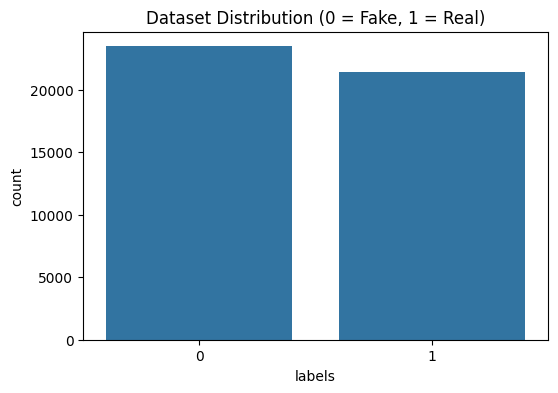

Null values:
 text      0
labels    0
dtype: int64


In [ ]:
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='labels', data=df)
plt.title('Dataset Distribution (0 = Fake, 1 = Real)')
plt.show()

# Check for null values
print("Null values:\n", df.isnull().sum())
df.dropna(inplace=True)

In [ ]:
# Prepare features (X) and target (y)
X = df['text'].values
y = df['labels'].values

# Split data: 80% Training, 20% Testing
# random_state ensures reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 35918
Testing set size: 8980


In [ ]:
# --- BERT MODEL CONFIGURATION ---
# 1. Preprocessing Layer:
# Converts raw text into token IDs suitable for BERT.
# We use the corresponding 'cased' preprocessor for the 'cased' BERT model.
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"

# 2. Encoder Layer (BERT Base Cased):
# Model: bert_en_cased_L-12_H-768_A-12
# L=12 hidden layers, H=768 hidden size, A=12 attention heads.
# Rationale: 'Cased' models distinguish between 'fake' and 'FAKE'.
# This is crucial for fake news detection where capitalization often indicates emphasis or clickbait.
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    preprocessing_layer = hub.KerasLayer(preprocess_url, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    encoder = hub.KerasLayer(encoder_url, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

    return tf.keras.Model(inputs=text_input, outputs=net)
model = build_classifier_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [ ]:
# COMPILE THE MODEL (Crucial Step)
# Optimizer: Adam (learning_rate=3e-5) is standard for BERT.
# Loss: Binary Crossentropy (since we have 0 or 1 labels).
print("\n Compiling model...")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\n Starting training...")
print("Note: Using default batch_size=32.")
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1, # Use 10% of the training data for validation
    epochs=3 # BERT converges quickly; 3 epochs are usually sufficient to avoid overfitting
)

print("\n Training completed!")

# 4. SAVE MODEL TO GOOGLE DRIVE
print(f" Saving model to Google Drive ({save_dir})... Please wait...")

# Save in 'SavedModel' format (Standard TensorFlow format which includes the computation graph)
model.save(save_dir)

print(" Model saved successfully! You can check it in your Google Drive folder.")


 Compiling model...

 Starting training...
Note: Using default batch_size=32.
Epoch 1/3
1011/1011 [==============================] - 964s 909ms/step - loss: 0.0127 - accuracy: 0.9958 - val_loss: 0.0016 - val_accuracy: 0.9997
Epoch 2/3
1011/1011 [==============================] - 926s 916ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9997
Epoch 3/3
1011/1011 [==============================] - 926s 916ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0029 - val_accuracy: 0.9997

 Training completed!
 Saving model to Google Drive (/content/drive/MyDrive/NLP_Projects/FakeNews_BERT_Cased)... Please wait...
 Model saved successfully! You can check it in your Google Drive folder.


Evaluating model on Test Set...
281/281 [==============================] - 89s 318ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

   Fake News       1.00      1.00      1.00      4688
   Real News       1.00      1.00      1.00      4292

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



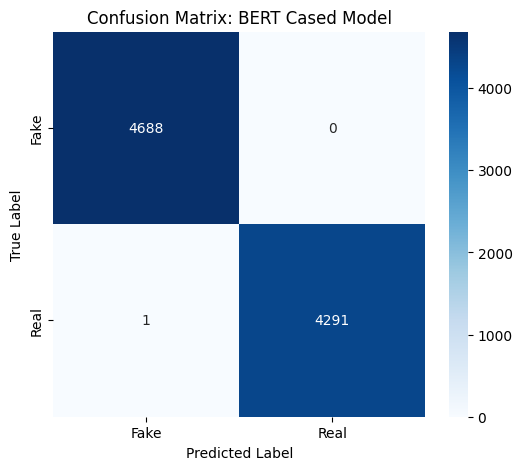

In [ ]:
# --- EVALUATION ---

print("Evaluating model on Test Set...")

# 1. Generate Predictions
# The model outputs probabilities (0 to 1). We threshold at 0.5.
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# 2. Print Classification Report
# This shows Precision, Recall, and F1-Score for both classes.
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Fake News', 'Real News']))

# 3. Visualize Confusion Matrix
# This helps identifying where the model gets confused (e.g., classifying Fake as Real).
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: BERT Cased Model')
plt.show()

In [ ]:
# --- INTERACTIVE REAL-TIME PREDICTION ---

def predict_user_input():
    """
    Runs an interactive loop allowing the user to input text via keyboard
    and get immediate predictions from the BERT model.
    """
    print("\n" + "="*50)
    print(" FAKE NEWS DETECTOR - INTERACTIVE MODE")
    print("Type a news headline and press Enter to check.")
    print("Type 'exit' or 'quit' to stop the program.")
    print("="*50 + "\n")

    while True:
        # Get input from the user
        user_text = input(" Enter News Headline: ")

        # Check for exit condition
        if user_text.lower() in ['exit', 'quit']:
            print("\nExiting program. Goodbye! 👋")
            break

        # Skip empty inputs
        if not user_text.strip():
            continue

        print("Thinking...", end="\r") # Simple loading effect

        # --- PREDICTION LOGIC ---
        # The model accepts a list of strings
        try:
            # Predict
            prob = model.predict([user_text], verbose=0)[0][0]

            # Determine Label and Confidence
            if prob > 0.5:
                label = "REAL NEWS "
                confidence = prob
                color_code = "\033[92m" # Green text
            else:
                label = "FAKE NEWS "
                confidence = 1 - prob
                color_code = "\033[91m" # Red text

            reset_code = "\033[0m" # Reset color

            # Display Result
            print(f"\n{color_code}▶ RESULT: {label}{reset_code}")
            print(f"▶ CONFIDENCE: {confidence:.2%}")
            print("-" * 50 + "\n")

        except Exception as e:
            print(f" An error occurred: {e}")

# Run the interactive function
predict_user_input()


 FAKE NEWS DETECTOR - INTERACTIVE MODE
Type a news headline and press Enter to check.
Type 'exit' or 'quit' to stop the program.

 Enter News Headline: HONG KONG (Reuters) - Typhoon Hato, a maximum category 10 storm, slammed into Hong Kong on Wednesday lashing the Asian financial hub with wind and rain that uprooted trees and forced most businesses to close, while in some places big waves flooded seaside streets. There were reports of 34 people injured in Hong Kong while in the city of Macau, across the Pearl River estuary, three people were killed, authorities there said. In Hong Kong, more than 450 flights were canceled, financial markets suspended and schools closed as Hato bore down, the first category 10 storm to hit the city since 2012.  I ve never seen one like this,  Garrett Quigley, a longtime resident of Lantau island to the west of the city, said of the storm.  Cars are half submerged and roads are impassable with flooding and huge trees down. It s crazy.   Many skyscrapers